# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
from wordcloud import WordCloud
import os

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# 1. Read Datas

In [2]:
# using the SQLite Table to read data.
sql = sqlite3.connect("database.sqlite")
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points
data = pd.read_sql_query("""select * from Reviews WHERE Score != 3""", sql)
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.

def partition(x):
    if x<3:
        return 0
    else:
        return 1 
#changing reviews with score less than 3 to be positive and vice-versa
part = data["Score"].map(partition)
data["Score"] = part

In [3]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


<b>Duplicate Datas</b>

In [4]:
new_data = pd.read_sql_query("""SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*) from Reviews
GROUP BY UserId
HAVING COUNT(*)>1""",sql)
new_data.head()

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
new_data[new_data["COUNT(*)"] == new_data["COUNT(*)"].max()]

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
57359,A3OXHLG6DIBRW8,B002O3VHXU,"C. F. Hill ""CFH""",1282176000,5,"Green Mountain ""Nantucket Blend"" K-Cups make a...",448


#  Exploratory Data Analysis

## 2. Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [6]:
data[data["UserId"]=="AR5J8UI46CURR"].sort_values(by="ProductId")

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
72060,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,1,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
127478,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,1,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
127440,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,1,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
67901,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,1,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
142859,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,1,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [7]:
data_sorted = data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
data_final = data_sorted.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print(f"Shape of dataset: {data_final.shape}")
print(f"About {round((1-data_final.shape[0]/data_sorted.shape[0])*100,2)}%\
 of the original datas has been deleted due to duplication")

Shape of dataset: (364173, 10)
About 30.74% of the original datas has been deleted due to duplication


<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [8]:
data_final[data_final["HelpfulnessDenominator"]<data_final["HelpfulnessNumerator"]]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
59301,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,1,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
41159,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,1,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [9]:
data_final = data_final[data_final["HelpfulnessDenominator"]>=data_final["HelpfulnessNumerator"]]
data_final.shape

(364171, 10)

In [10]:
data_final["Score"].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

In [11]:
percent = data_final["Score"].value_counts().min()/len(data_final["Score"])
print(f"Negative reviews is just a {round(percent*100,2)}% of total dataset")

Negative reviews is just a 15.68% of total dataset


So obviously, the dataset is highly unbalanced and we cannot use accuracy score as the evaluation metrics.

# 3.  Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [12]:
print(data_final["Text"].values[0])
print("="*100)
print(data_final["Text"].values[1000])
print("="*100)
print(data_final["Text"].values[1500])
print("="*100)
print(data_final["Text"].values[1700])
print("="*100)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [13]:
from bs4 import BeautifulSoup
#Remove HTML tags and URL from the reviews.
def html_tag(phrase):
    http_remove = re.sub(r"http\S+", "",phrase)
    html_remove = BeautifulSoup(http_remove, 'lxml').get_text()
    return html_remove

In [14]:
phrase = data_final["Text"].values[0]
print(f"Before tag Remover: \n {phrase}")
print("="*90)
phrase = html_tag(data_final["Text"].values[0])
print(f"After tag removed: \n {phrase}")

Before tag Remover: 
 this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
After tag removed: 
 this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [15]:
import re
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [16]:
phrase = data_final["Text"].values[1500]
print(f"Before: {phrase}")
print("="*90)
r1500 = html_tag(data_final["Text"].values[1500])
r1500 = decontracted(r1500)
print(f"After: {r1500}")

Before: Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today's Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70's it was poisonous until they figured out a way to fix that. I still like it but it could be better.
After: Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say othe

In [17]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [18]:
data_final.shape

(364171, 10)

In [19]:
data_final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...


In [20]:
from tqdm import tqdm

In [21]:
processed_review = []
for i in tqdm(data_final["Text"].values):
    sentance = html_tag(i)
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance)
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = " ".join(i.lower() for i in sentance.split() if i.lower() not in stopwords)
    processed_review.append(sentance)

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [01:53<00:00, 3205.86it/s]


In [22]:
data_final["Clean text"] = processed_review

In [23]:
len(processed_review)

364171

# 4. Bag of Words

In [24]:
from sklearn.model_selection import cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [25]:
class plot():
    def __init__():
        pass
    
    def confusion_mat(estimator,train,test):
        plt.figure(figsize=(18,6))
        plt.subplot(121)
        cm = confusion_matrix(y_train, estimator.predict(train), labels=[1,0])
        cm_df = pd.DataFrame(data=cm,columns=["Predicted-1","Predicted-0"],index=["Actual-1","Actual-0"])
        sns.heatmap(cm_df,cmap="RdYlGn",annot=True)
        plt.title("Heatmap of Confusion Matrix(Train)",fontsize=15)

        plt.subplot(122)
        cm = confusion_matrix(y_test, estimator.predict(test), labels=[1,0])
        cm_df = pd.DataFrame(data=cm,columns=["Predicted-1","Predicted-0"],index=["Actual-1","Actual-0"])
        sns.heatmap(cm_df,cmap="RdYlGn",annot=True)
        plt.title("Heatmap of Confusion Matrix (Test)",fontsize=15)
        plt.show()
        
    def accuracy_mat(parameter,TrainAUC,CVAUC,parameter_name):
        plt.figure(figsize=(9,6))
        sns.set_style(style="whitegrid")
        sns.lineplot(np.log(parameter), TrainAUC, color="r", label="Train AUC", marker="o")
        sns.lineplot(np.log(parameter), CVAUC, color="b", label="CV AUC",marker="o")
        plt.xlabel(f"Hyper Parameter {parameter_name}",fontsize=13)
        plt.ylabel("AUC Score",fontsize=13)
        plt.title("Accuracy Plot", fontsize=14)
        plt.show()
        dictionary = dict(zip(cv_auc, parameter))
        print(f"Highest AUC for CV is obtained at {parameter_name}={dictionary[max(cv_auc)]}")
        
    def auc_mat(estimator,train,test):
        train_fpr, train_tpr, train_thr = roc_curve(y_train, estimator.predict_proba(train)[:,1])
        test_fpr, test_tpr, test_thr = roc_curve(y_test, estimator.predict_proba(test)[:,1])
        plt.figure(figsize=(9,6))
        plt.plot(train_fpr,train_tpr,"r",label=f"Train ROC Curve, Area={round(auc(train_fpr,train_tpr),3)}")
        plt.plot(test_fpr,test_tpr,"b",label=f"Test ROC Curve, Area={round(auc(test_fpr,test_tpr),3)}")
        plt.plot([0,1],[0,1],'k--')
        plt.title("ROC Curve",fontsize=15)
        plt.legend(loc="best")
        plt.xlabel("False Positive Rate (1-Specificity)",fontsize=13)
        plt.ylabel("True Positive Rate",fontsize=13)
        plt.show()
        print(f"AUC of train datas: {auc(train_fpr,train_tpr)}")
        print(f"AUC of test datas: {auc(test_fpr,test_tpr)}")
        
    def top_features(estimator,vectorizer):
        df=pd.DataFrame(data=estimator.coef_.T, index=vectorizer.get_feature_names(),columns=["Coef"])
        print("Top Negative features")
        print(df.sort_values(by='Coef',ascending=True).head())
        print("="*20)
        print("Top Poistive features")
        print(df.sort_values(by='Coef',ascending=False).head())
        
    def word_cloud(estimator,vectorizer):
        df=pd.DataFrame(data=estimator.coef_.T, index=vectorizer.get_feature_names(),columns=["Coef"])
        df["Words"] = df.index
        worddf = df.reset_index(drop=True)
        for i in [True,False]:
            word_sort = worddf.sort_values(by='Coef',ascending=i)
            wordstr = word_sort.Words.str.cat(sep=' ')
            wordcloud = WordCloud(background_color="white").generate(wordstr)
            if i == True:
                print("Top Negative Features")
            else:
                print("Top Positive Features")
            plt.figure(figsize=(10,7))
            plt.imshow(wordcloud)
            plt.axis('off')
            plt.show()

In [26]:
x = data_final["Clean text"][0:100000]
y = data_final["Score"][0:100000]

In [27]:
xx, x_cv, yy, y_cv = train_test_split(x, y, test_size=0.2, random_state=1)
x_train, x_test, y_train, y_test = train_test_split(xx,yy, test_size=0.2, random_state=1)
print(f"X CV Shape: {x_cv.shape}")
print(f"Y CV Shape: {y_cv.shape}")
print(f"X train shape: {x_train.shape}")
print(f"Y train shape: {y_train.shape}")
print(f"X test shape: {x_test.shape}")
print(f"Y test shape: {y_test.shape}")

X CV Shape: (20000,)
Y CV Shape: (20000,)
X train shape: (64000,)
Y train shape: (64000,)
X test shape: (16000,)
Y test shape: (16000,)


## 4.1 L1 Logistics Regression on BOW

In [28]:
bow = CountVectorizer()
bow.fit(x_train)
train_bow = bow.transform(x_train)
cv_bow = bow.transform(x_cv)
test_bow = bow.transform(x_test)
print(f"Shape of Train bow: {train_bow.get_shape()}")
print(f"Shape of CV bow: {cv_bow.get_shape()}")
print(f"Shape of Test bow: {test_bow.get_shape()}")

Shape of Train bow: (64000, 48234)
Shape of CV bow: (20000, 48234)
Shape of Test bow: (16000, 48234)


In [29]:
from sklearn.linear_model import LogisticRegression

In [30]:
C = [0.0001,0.001,0.01,0.1,1,10,100]
train_auc = []
cv_auc = []
for i in tqdm(C):
    reg = LogisticRegression(penalty='l1',C=i)
    reg.fit(train_bow,y_train)
    train_bow_auc = roc_auc_score(y_train, reg.predict_proba(train_bow)[:,1])
    cv_bow_auc = roc_auc_score(y_cv, reg.predict_proba(cv_bow)[:,1])
    train_auc.append(train_bow_auc)
    cv_auc.append(cv_bow_auc)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  2.14s/it]


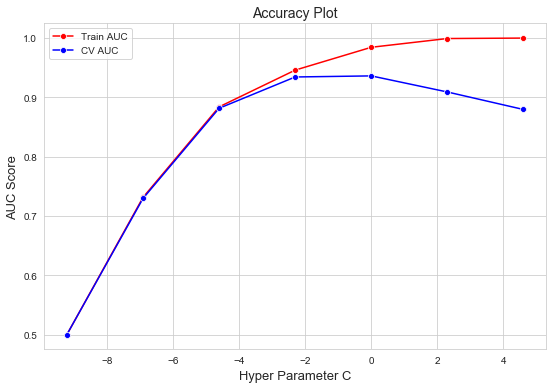

Highest AUC for CV is obtained at C=1


In [31]:
plot.accuracy_mat(C,train_auc,cv_auc,"C")

In [32]:
reg = LogisticRegression(penalty='l1',C=1)
reg.fit(train_bow,y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

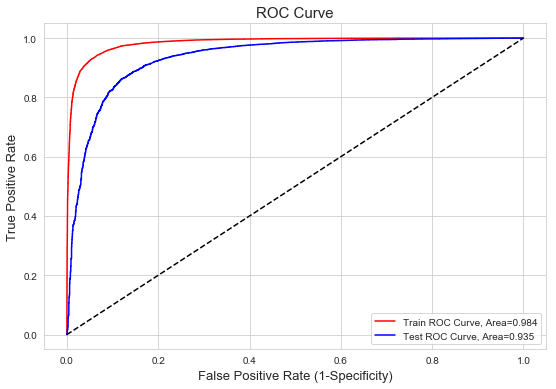

AUC of train datas: 0.984388284538634
AUC of test datas: 0.93538475824112


In [33]:
plot.auc_mat(reg,train_bow,test_bow)

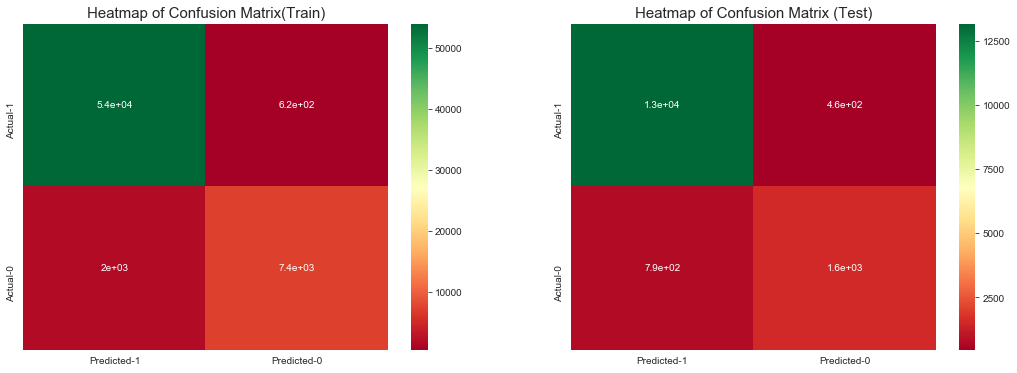

In [34]:
plot.confusion_mat(reg, train_bow, test_bow)

In [35]:
plot.top_features(reg,bow)

Top Negative features
              Coef
itfor    -4.614987
schar    -4.499354
nome     -4.305147
downhill -3.474876
weakest  -3.435303
Top Poistive features
                 Coef
undeniably   4.728726
basement     3.569483
versatile    3.480603
discovering  3.388625
med          3.314722


Top Negative Features


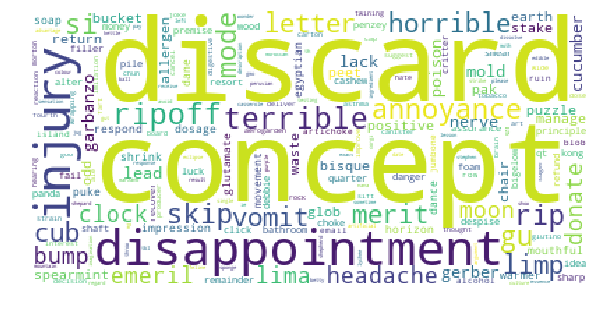

Top Positive Features


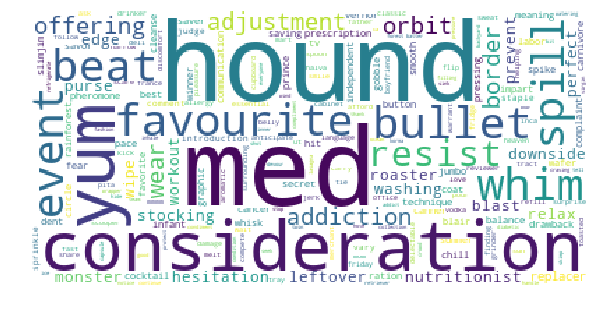

In [36]:
plot.word_cloud(reg,bow)

## 4.2 L2 Logistics regression on BOW

In [37]:
C = [0.0001,0.001,0.01,0.1,1,10,100]
train_auc = []
cv_auc = []
for i in tqdm(C):
    reg2 = LogisticRegression(penalty='l2',C=i)
    reg2.fit(train_bow,y_train)
    train_bow_auc = roc_auc_score(y_train, reg2.predict_proba(train_bow)[:,1])
    cv_bow_auc = roc_auc_score(y_cv, reg2.predict_proba(cv_bow)[:,1])
    train_auc.append(train_bow_auc)
    cv_auc.append(cv_bow_auc)

 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:28<00:06,  6.99s/it]C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:42<00:00,  9.06s/it]


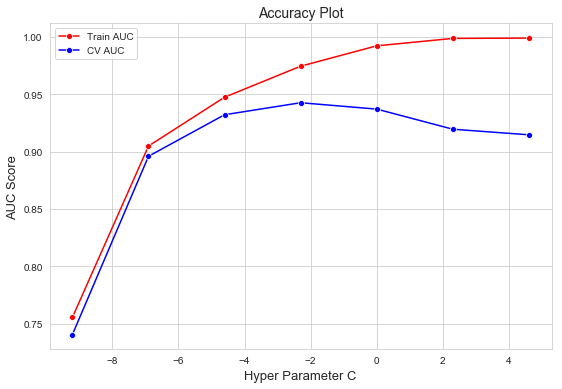

Highest AUC for CV is obtained at C=0.1


In [38]:
plot.accuracy_mat(C,train_auc,cv_auc,"C")

In [39]:
log_reg = LogisticRegression(C=0.1)
log_reg.fit(train_bow,y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

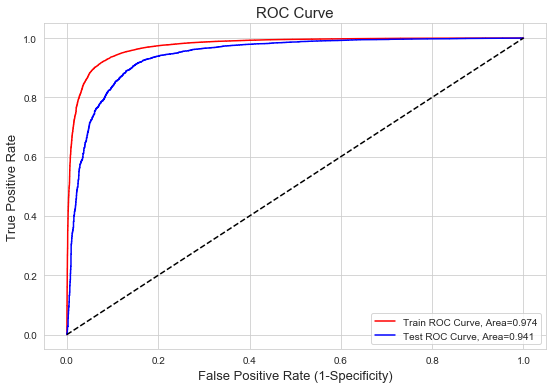

AUC of train datas: 0.9742911937600643
AUC of test datas: 0.9411770968989025


In [40]:
plot.auc_mat(log_reg,train_bow,test_bow)

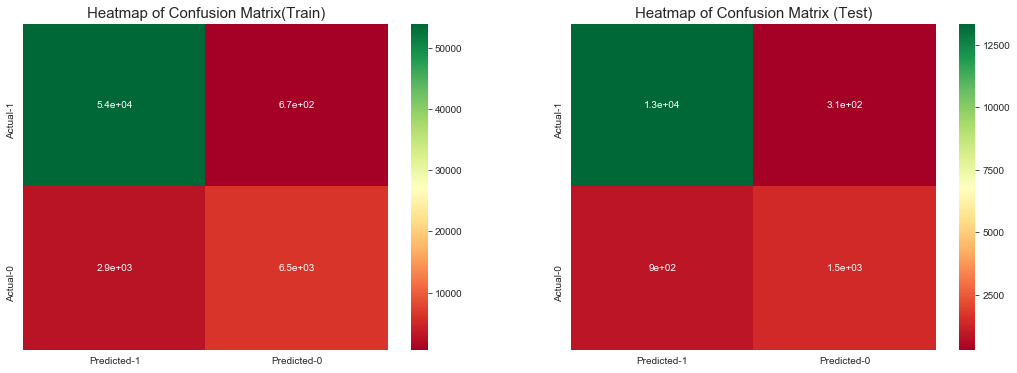

In [41]:
plot.confusion_mat(log_reg,train_bow,test_bow)

In [42]:
plot.top_features(log_reg,bow)

Top Negative features
                   Coef
worst         -1.679140
disappointing -1.569660
terrible      -1.476251
awful         -1.355953
disappointed  -1.318309
Top Poistive features
               Coef
delicious  1.407272
excellent  1.368202
awesome    1.317613
loves      1.286324
perfect    1.227555


Top Negative Features


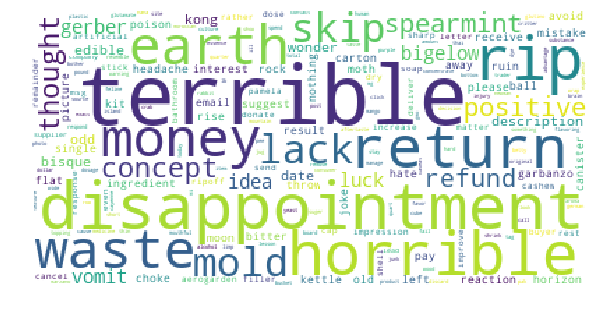

Top Positive Features


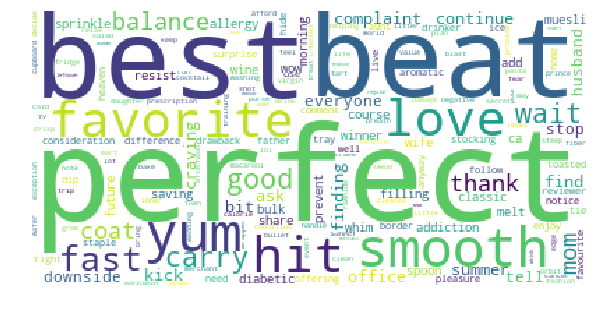

In [43]:
plot.word_cloud(log_reg,bow)

# 5. TFIDF

In [44]:
tfidf = TfidfVectorizer()

In [45]:
tfidf.fit(x_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [46]:
train_tfidf = tfidf.transform(x_train)
cv_tfidf = tfidf.transform(x_cv)
test_tfidf = tfidf.transform(x_test)

In [47]:
from sklearn.linear_model import LogisticRegression

## 5.1 L1 Logistics Regression on TFIDF

In [48]:
C = [0.0001,0.001,0.01,0.1,1,10,100]
train_auc = []
cv_auc = []
for i in tqdm(C):
    reg1 = LogisticRegression(penalty='l1',C=i)
    reg1.fit(train_tfidf,y_train)
    train_tfidf_auc = roc_auc_score(y_train, reg1.predict_proba(train_tfidf)[:,1])
    cv_tfidf_auc = roc_auc_score(y_cv, reg1.predict_proba(cv_tfidf)[:,1])
    train_auc.append(train_tfidf_auc)
    cv_auc.append(cv_tfidf_auc)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.17s/it]


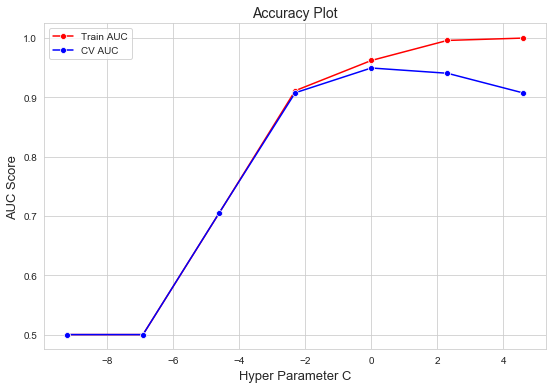

Highest AUC for CV is obtained at C=1


In [49]:
plot.accuracy_mat(C,train_auc,cv_auc,"C")

In [50]:
reg2 = LogisticRegression(penalty='l1',C=1)
reg2.fit(train_tfidf,y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

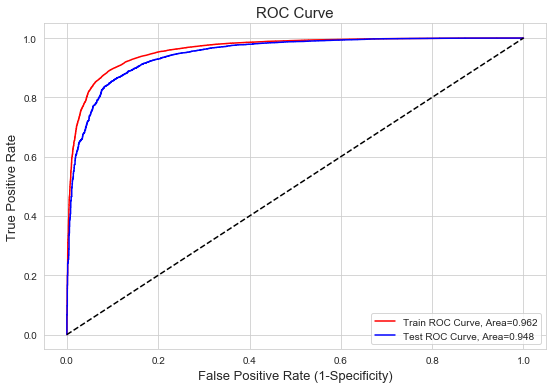

AUC of train datas: 0.9619381691048043
AUC of test datas: 0.947815824477593


In [51]:
plot.auc_mat(reg2,train_tfidf,test_tfidf)

In [52]:
plot.top_features(reg2,tfidf)

Top Negative features
                     Coef
worst          -12.461844
disappointing  -10.632820
awful          -10.109896
threw           -9.075189
disappointment  -8.870434
Top Poistive features
                Coef
great      15.716202
best       13.291650
delicious  13.178500
perfect    11.307871
excellent  10.830115


Top Negative Features


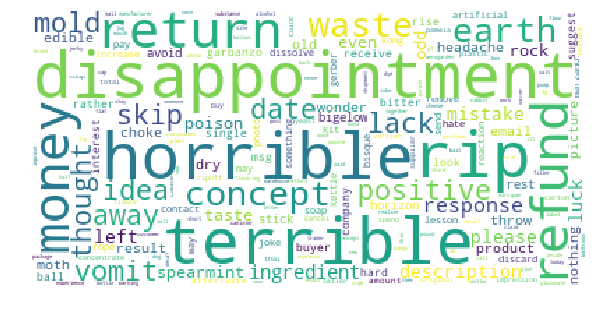

Top Positive Features


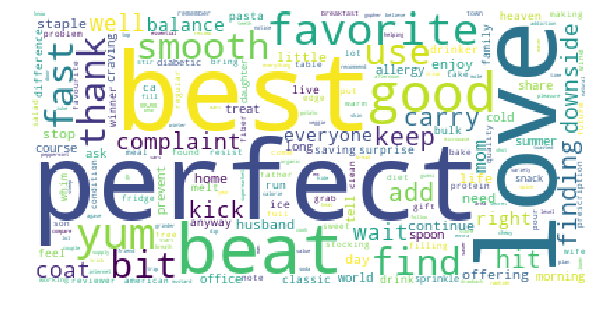

In [53]:
plot.word_cloud(reg2,tfidf)

## 5.2 L2 Logistics Regression on TFIDF

In [54]:
C = [0.0001,0.001,0.01,0.1,1,10,100]
train_auc = []
cv_auc = []
for i in tqdm(C):
    reg3 = LogisticRegression(penalty='l2',C=i)
    reg3.fit(train_tfidf,y_train)
    train_tfidf_auc = roc_auc_score(y_train, reg3.predict_proba(train_tfidf)[:,1])
    cv_tfidf_auc = roc_auc_score(y_cv, reg3.predict_proba(cv_tfidf)[:,1])
    train_auc.append(train_tfidf_auc)
    cv_auc.append(cv_tfidf_auc)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:06<00:00,  1.33s/it]


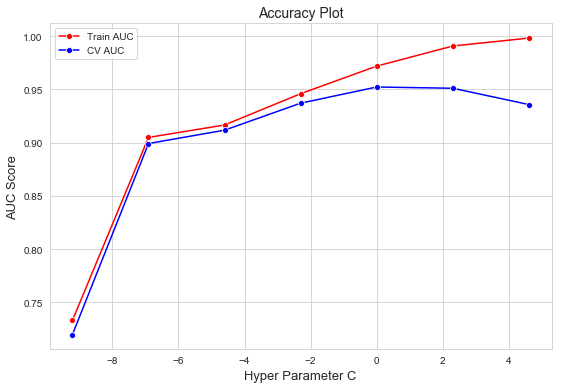

Highest AUC for CV is obtained at C=1


In [55]:
plot.accuracy_mat(C,train_auc,cv_auc,"C")

In [56]:
reg4 = LogisticRegression(C=1,penalty='l2')
reg4.fit(train_tfidf,y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

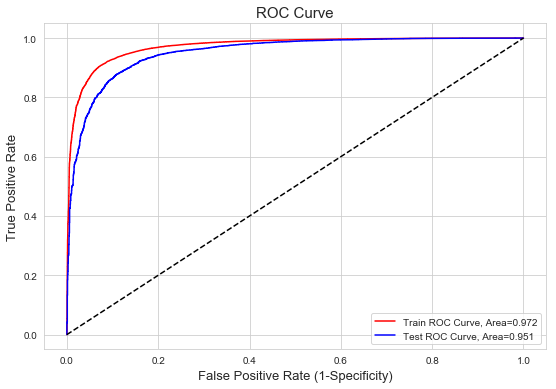

AUC of train datas: 0.9718284001312903
AUC of test datas: 0.951086436153181


In [57]:
plot.auc_mat(reg4,train_tfidf,test_tfidf)

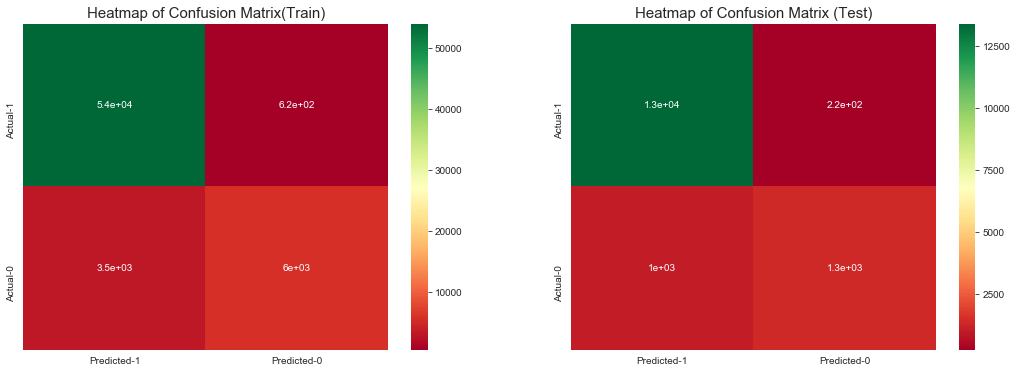

In [58]:
plot.confusion_mat(reg4,train_tfidf,test_tfidf)

In [59]:
plot.top_features(reg4,tfidf)

Top Negative features
                  Coef
not          -7.577413
worst        -6.732780
disappointed -6.288771
awful        -5.953785
terrible     -5.762089
Top Poistive features
                Coef
great      11.258681
best        8.754780
delicious   7.817388
love        7.217579
perfect     6.566873


Top Negative Features


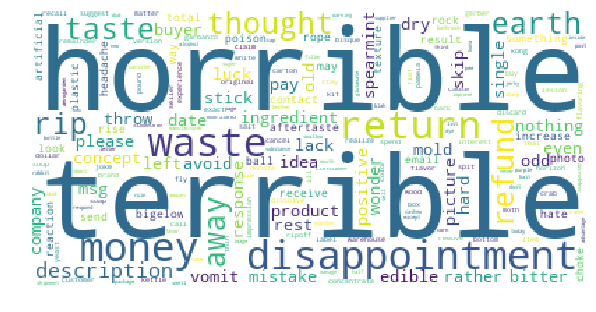

Top Positive Features


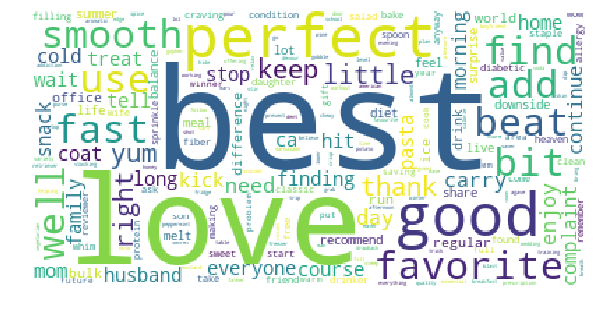

In [60]:
plot.word_cloud(reg4,tfidf)

# 6. Average W2V (Word to Vector)

In [61]:
list_of_sentance=[]
for sentance in tqdm(x_train):
    list_of_sentance.append(sentance.split())
print(f"Shape of X Train : {x_train.shape}")
w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
train_w2v = []
for sent in tqdm(list_of_sentance):
    word_count = 0
    word_vector = np.zeros(50)
    for words in sent:
        if words in w2v_words:
            word_count +=1 
            each_word_vect = w2v_model.wv[words]
            word_vector += each_word_vect
    if word_count != 0: 
        word_vector /= word_count
    train_w2v.append(word_vector)
print(f"Length of train_w2v: {len(train_w2v)}")
############################################################################
############################################################################
list_of_sentance=[]
for sentance in tqdm(x_cv):
    list_of_sentance.append(sentance.split())
print(f"Shape of X CV : {x_cv.shape}")
w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
cv_w2v = []
for sent in tqdm(list_of_sentance):
    word_count = 0
    word_vector = np.zeros(50)
    for words in sent:
        if words in w2v_words:
            word_count +=1 
            each_word_vect = w2v_model.wv[words]
            word_vector += each_word_vect
    if word_count != 0: 
        word_vector /= word_count
    cv_w2v.append(word_vector)
print(f"Length of cv_w2v: {len(cv_w2v)}")
####################################################################################
####################################################################################
list_of_sentance=[]
for sentance in tqdm(x_test):
    list_of_sentance.append(sentance.split())
print(f"Shape of X Test : {x_test.shape}")
w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
test_w2v = []
for sent in tqdm(list_of_sentance):
    word_count = 0
    word_vector = np.zeros(50)
    for words in sent:
        if words in w2v_words:
            word_count +=1 
            each_word_vect = w2v_model.wv[words]
            word_vector += each_word_vect
    if word_count != 0: 
        word_vector /= word_count
    test_w2v.append(word_vector)
print(f"Length of test_w2v: {len(test_w2v)}")

100%|████████████████████████████████████████████████████████████████████████| 64000/64000 [00:00<00:00, 172158.77it/s]


Shape of X Train : (64000,)


100%|███████████████████████████████████████████████████████████████████████████| 64000/64000 [01:33<00:00, 686.85it/s]


Length of train_w2v: 64000


100%|████████████████████████████████████████████████████████████████████████| 20000/20000 [00:00<00:00, 280993.39it/s]


Shape of X CV : (20000,)


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:23<00:00, 840.39it/s]


Length of cv_w2v: 20000


100%|████████████████████████████████████████████████████████████████████████| 16000/16000 [00:00<00:00, 260094.74it/s]


Shape of X Test : (16000,)


100%|███████████████████████████████████████████████████████████████████████████| 16000/16000 [00:18<00:00, 884.48it/s]


Length of test_w2v: 16000


## 6.1 L1 Logistics Regression on Average W2V

In [62]:
C = [0.0001,0.001,0.01,0.1,1,10,100]
train_auc = []
cv_auc = []
for i in tqdm(C):
    reg1 = LogisticRegression(penalty='l1',C=i)
    reg1.fit(train_w2v,y_train)
    train_w2v_auc = roc_auc_score(y_train, reg1.predict_proba(train_w2v)[:,1])
    cv_w2v_auc = roc_auc_score(y_cv, reg1.predict_proba(cv_w2v)[:,1])
    train_auc.append(train_w2v_auc)
    cv_auc.append(cv_w2v_auc)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:20<00:00,  3.54s/it]


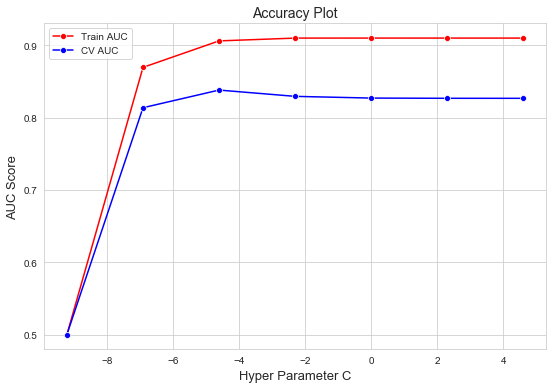

Highest AUC for CV is obtained at C=0.01


In [63]:
plot.accuracy_mat(C,train_auc,cv_auc,"C")

In [64]:
reg2 = LogisticRegression(penalty='l1',C=0.01)
reg2.fit(train_w2v,y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

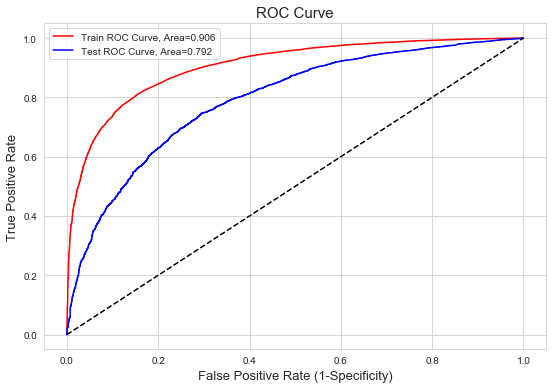

AUC of train datas: 0.9059885240256277
AUC of test datas: 0.7921737881279921


In [65]:
plot.auc_mat(reg2, train_w2v, test_w2v)

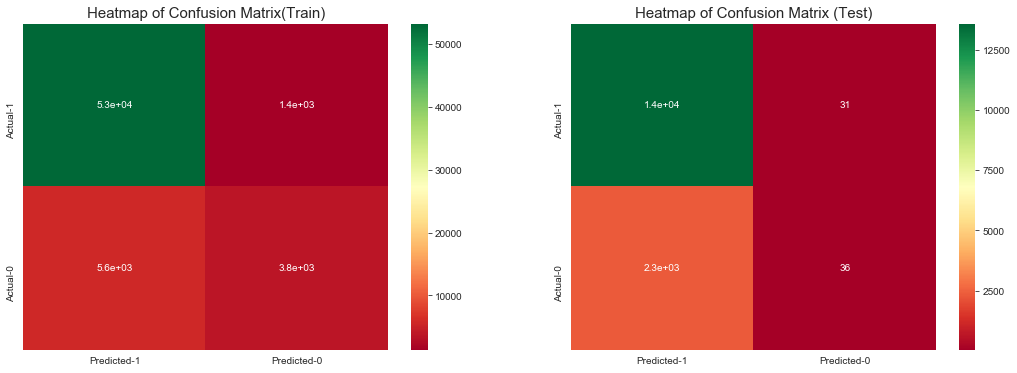

In [66]:
plot.confusion_mat(reg2,train_w2v, test_w2v)

## 6.2 L2 Logistics Regression on Average W2V

In [67]:
C = [0.0001,0.001,0.01,0.1,1,10,100]
train_auc = []
cv_auc = []
for i in tqdm(C):
    log_reg1 = LogisticRegression(penalty='l2',C=i)
    log_reg1.fit(train_w2v,y_train)
    train_w2v_auc = roc_auc_score(y_train, log_reg1.predict_proba(train_w2v)[:,1])
    cv_w2v_auc = roc_auc_score(y_cv, log_reg1.predict_proba(cv_w2v)[:,1])
    train_auc.append(train_w2v_auc)
    cv_auc.append(cv_w2v_auc)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.07it/s]


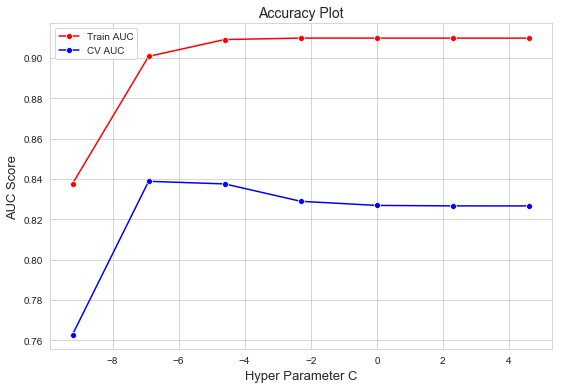

Highest AUC for CV is obtained at C=0.001


In [68]:
plot.accuracy_mat(C,train_auc,cv_auc,"C")

In [69]:
log_reg2 = LogisticRegression(C=100, penalty='l2')
log_reg2.fit(train_w2v,y_train)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

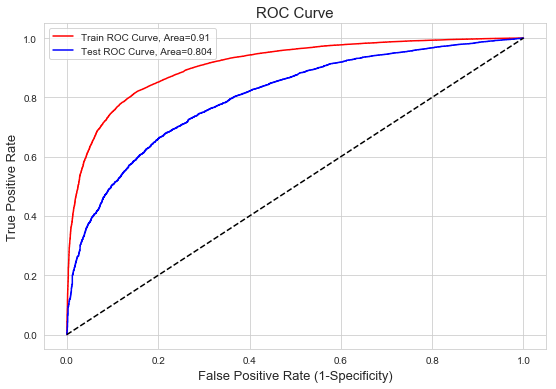

AUC of train datas: 0.9098761951352257
AUC of test datas: 0.8037330674031041


In [70]:
plot.auc_mat(log_reg2,train_w2v,test_w2v)

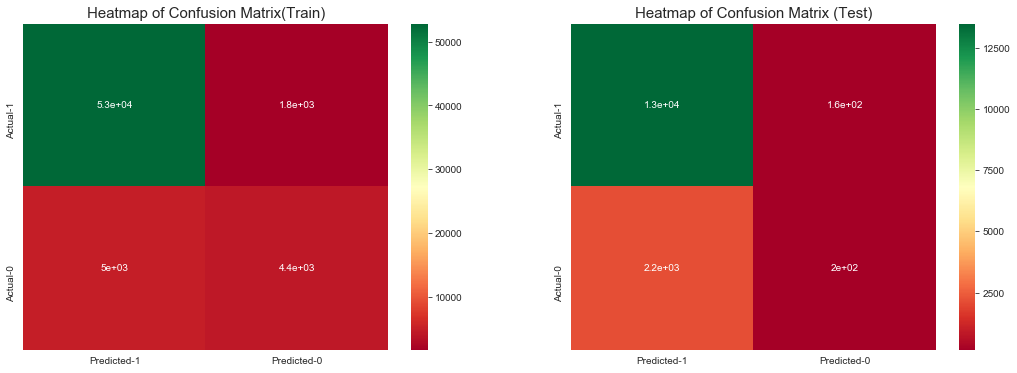

In [71]:
plot.confusion_mat(log_reg2,train_w2v,test_w2v)

# 7. TFIDF weighted W2V

In [72]:
list_of_sentance=[]
for sentance in tqdm(x_train):
    list_of_sentance.append(sentance.split())
    
model = TfidfVectorizer()
model.fit(x_train)
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
tfidf_feat = model.get_feature_names() 
w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)


train_tfidf_w2v = [];
for sent in tqdm(list_of_sentance): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent:
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    train_tfidf_w2v.append(sent_vec)

print(f"Shape of X Train: {x_train.shape}")
print(f"Length of train_tfidf_w2v {len(train_tfidf_w2v)}")
########################################################################
########################################################################


list_of_sentance=[]
for sentance in tqdm(x_cv):
    list_of_sentance.append(sentance.split())

model = TfidfVectorizer()
model.fit(x_cv)
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
tfidf_feat = model.get_feature_names() # tfidf words/col-names
w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)


cv_tfidf_w2v = [];
for sent in tqdm(list_of_sentance): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent:
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    cv_tfidf_w2v.append(sent_vec)
    
print(f"Shape of X CV: {x_cv.shape}")
print(f"Length of cv_tfidf_w2v {len(cv_tfidf_w2v)}")
###################################################################################
###################################################################################

list_of_sentance=[]
for sentance in tqdm(x_test):
    list_of_sentance.append(sentance.split())

model = TfidfVectorizer()
model.fit(x_test)
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
tfidf_feat = model.get_feature_names()
w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)


test_tfidf_w2v = [];
for sent in tqdm(list_of_sentance): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent:
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    test_tfidf_w2v.append(sent_vec)
    
print(f"Shape of X Test: {x_test.shape}")
print(f"Length of test_tfidf_w2v {len(test_tfidf_w2v)}")

100%|████████████████████████████████████████████████████████████████████████████| 64000/64000 [21:49<00:00, 45.19it/s]


Shape of X Train: (64000,)
Length of train_tfidf_w2v 64000


100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [03:52<00:00, 86.20it/s]


Shape of X CV: (20000,)
Length of cv_tfidf_w2v 20000


100%|████████████████████████████████████████████████████████████████████████████| 16000/16000 [02:53<00:00, 92.10it/s]


Shape of X Test: (16000,)
Length of test_tfidf_w2v 16000


## 7.1 L1 Logistics Regression on TFIDF weighted w2v

In [73]:
C = [0.0001,0.001,0.01,0.1,1,10,100]
train_auc = []
cv_auc = []
for i in tqdm(C):
    reg1 = LogisticRegression(penalty='l1',C=i)
    reg1.fit(train_tfidf_w2v,y_train)
    train_tfidfw2v_auc = roc_auc_score(y_train, reg1.predict_proba(train_tfidf_w2v)[:,1])
    cv_tfidfw2v_auc = roc_auc_score(y_cv, reg1.predict_proba(cv_tfidf_w2v)[:,1])
    train_auc.append(train_tfidfw2v_auc)
    cv_auc.append(cv_tfidfw2v_auc)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:12<00:00,  2.26s/it]


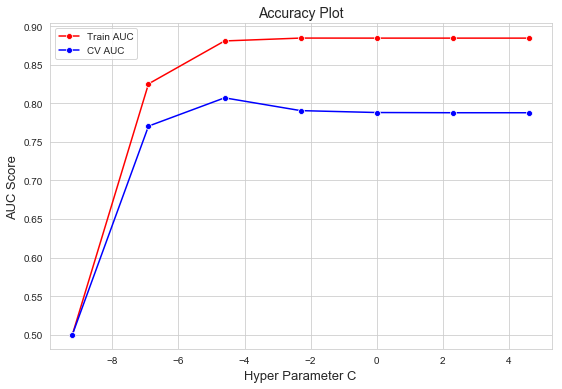

Highest AUC for CV is obtained at C=0.01


In [74]:
plot.accuracy_mat(C,train_auc,cv_auc,"C")

In [75]:
reg2 = LogisticRegression(C=10,penalty='l1')
reg2.fit(train_tfidf_w2v,y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

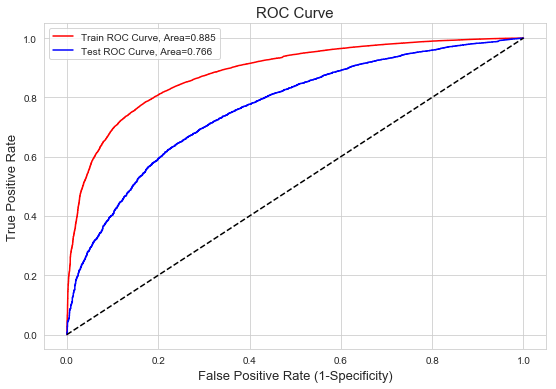

AUC of train datas: 0.8847269779480926
AUC of test datas: 0.7663019825144594


In [76]:
plot.auc_mat(reg2,train_tfidf_w2v,test_tfidf_w2v)

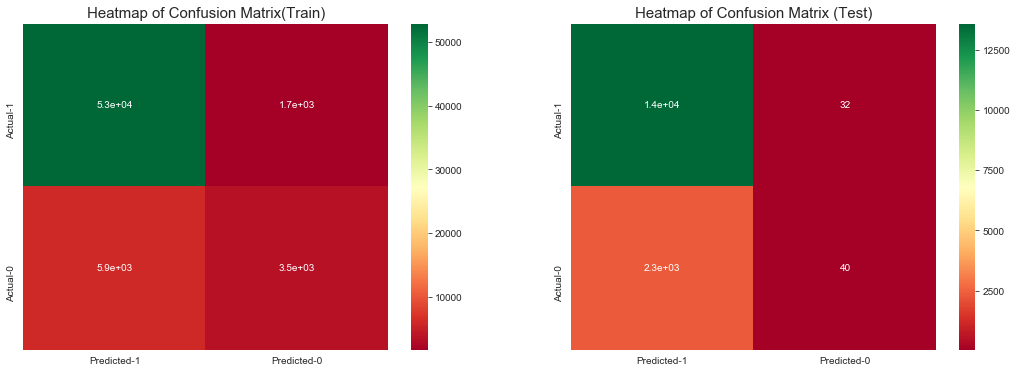

In [77]:
plot.confusion_mat(reg2, train_tfidf_w2v, test_tfidf_w2v)

## 7.2 L2 Logistics Regression on TFIDF weighted w2v

In [78]:
C = [0.0001,0.001,0.01,0.1,1,10,100]
train_auc = []
cv_auc = []
for i in tqdm(C):
    reg2 = LogisticRegression(penalty='l2',C=i)
    reg2.fit(train_tfidf_w2v,y_train)
    train_tfidfw2v_auc = roc_auc_score(y_train, reg2.predict_proba(train_tfidf_w2v)[:,1])
    cv_tfidfw2v_auc = roc_auc_score(y_cv, reg2.predict_proba(cv_tfidf_w2v)[:,1])
    train_auc.append(train_tfidfw2v_auc)
    cv_auc.append(cv_tfidfw2v_auc)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:06<00:00,  1.09s/it]


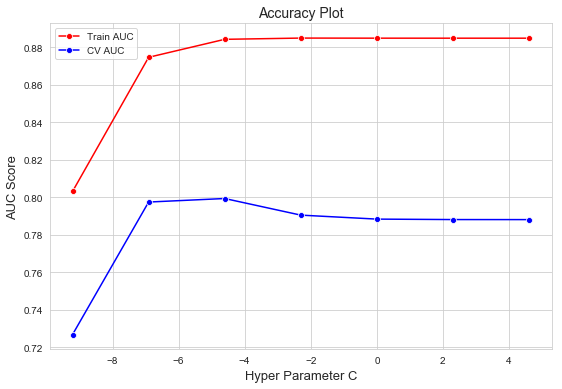

Highest AUC for CV is obtained at C=0.01


In [79]:
plot.accuracy_mat(C,train_auc,cv_auc,"C")

In [80]:
reg3 = LogisticRegression(C=100, penalty='l2')
reg3.fit(train_tfidf_w2v,y_train)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

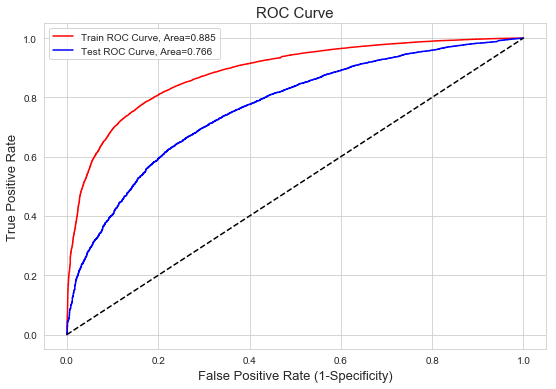

AUC of train datas: 0.8847304787084078
AUC of test datas: 0.7663628507680778


In [81]:
plot.auc_mat(reg3,train_tfidf_w2v,test_tfidf_w2v)

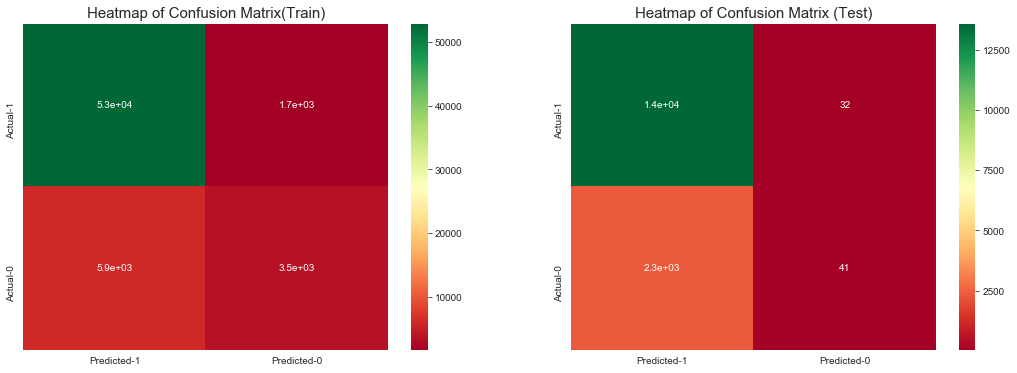

In [82]:
plot.confusion_mat(reg3,train_tfidf_w2v,test_tfidf_w2v)

# 8. Conclusion

In [83]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ["Vectorizer","Algorithm","HyperParamerer C","Train AUC", "Test AUC"]
table.add_row(["BOW","L1 Logistics Regression","1","0.98","0.93"])
table.add_row(["BOW","L2 Logistics Regression","0.1","0.97","0.94"])
table.add_row(["TFIDF","L1 Logistics Regression","1","0.96","0.94"])
table.add_row(["TFIDF","L2 Logistics Regression","0.01","0.97","0.95"])
table.add_row(["AVG W2V","L1 Logistics Regression","1","0.90","0.80"])
table.add_row(["AVG_W2V","L2 Logistics Regression","100","0.90","0.80"])
table.add_row(["TFIDF Weighted W2V","L1 Logistics Regression","10","0.87","0.75"])
table.add_row(["TFIDF Weighted W2V","L2 Logistics Regression","100","0.87","0.75"])
print(table)

+--------------------+-------------------------+------------------+-----------+----------+
|     Vectorizer     |        Algorithm        | HyperParamerer C | Train AUC | Test AUC |
+--------------------+-------------------------+------------------+-----------+----------+
|        BOW         | L1 Logistics Regression |        1         |    0.98   |   0.93   |
|        BOW         | L2 Logistics Regression |       0.1        |    0.97   |   0.94   |
|       TFIDF        | L1 Logistics Regression |        1         |    0.96   |   0.94   |
|       TFIDF        | L2 Logistics Regression |       0.01       |    0.97   |   0.95   |
|      AVG W2V       | L1 Logistics Regression |        1         |    0.90   |   0.80   |
|      AVG_W2V       | L2 Logistics Regression |       100        |    0.90   |   0.80   |
| TFIDF Weighted W2V | L1 Logistics Regression |        10        |    0.87   |   0.75   |
| TFIDF Weighted W2V | L2 Logistics Regression |       100        |    0.87   |   0.75   |